In [ ]:
# default_exp samplers.protocol_samplers

# Protocol Samplers

> Collection of different samplers for sampling logical failure rates from quantum error correction protocols

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#export
import qsam.math as math
from qsam.circuit import partition, make_hash, unpack
from qsam.fault_generators import Depolar
from qsam.protocol import iterate
from qsam.samplers.sampler_mixins import SubsetAnalytics
from qsam.samplers.datatypes import CountNode, Variable, Constant, Fail, NoFail, Tree

import numpy as np
from tqdm import tqdm

In [ ]:
#export
ONE_QUBIT_GATES = {'H', 'X', 'Z'}
TWO_QUBIT_GATES = {'CNOT'}

GATE_GROUPS = {'p': ONE_QUBIT_GATES | TWO_QUBIT_GATES,
               'p1': ONE_QUBIT_GATES,
               'p2': TWO_QUBIT_GATES,
               }

In [ ]:
#export

class Sampler:
    def __init__(self, protocol, simulator):
        self.protocol = protocol
        self.simulator = simulator
        self.n_qubits = len(set(q for c in protocol._circuits.values() for q in unpack(c)))
                         
    def run(self, n_samples, sample_range, err_params, RSE_target=1e-1, var=math.Wilson_var, eval_fns=None, verbose=False):
        
        # RSE: rel. standard error target
        fail_cnts = np.zeros(len(sample_range)) # one fail counter per sample point
        partitions = {circuit_hash: [partition(circuit, GATE_GROUPS[k]) for k in err_params.keys()]
                     for circuit_hash, circuit in self.protocol._circuits.items()}
                
        for i,sample_pt in enumerate(sample_range): # n_samples at sample_pt
            
            p_phy = np.array(list(err_params.values())) * sample_pt
            
            for j in tqdm(range(n_samples)):
                
                sim = self.simulator(self.n_qubits)
                p_it = iterate(self.protocol, eval_fns)
                node = next(p_it)
                
                if verbose: print(f'--- Protocol run {j} ---')
                
                while node:
                    
                    if not self.protocol.out_edges(node):
                        fail_cnts[i] += 1
                        break
                    
                    circuit_hash, circuit = self.protocol.circuit_from_node(node)
                    if not circuit._noisy or circuit_hash not in partitions.keys():
                        msmt = sim.run(circuit)
                    else:
                        circuit_partitions = partitions[circuit_hash]
                        faults = Depolar.faults_from_probs(circuit_partitions, p_phy)
                        fault_circuit = Depolar.gen_circuit(len(circuit), faults)
                        msmt = sim.run(circuit, fault_circuit)
                    _node = node
                    node = p_it.send(msmt if msmt==None else int(msmt,2))

                    if verbose:
                        pauli_faults = [] if not circuit._noisy else [f'Tick {tick} :: {fault_circuit[tick]}' for tick,_ in faults]
                        if _node == 'COR': print(f"Node {_node}, Circuit {circuit} -> {node}")
                        else: print(f"Node {_node}, Faults {pauli_faults}, Measured {msmt}-> {node}")
                
                if j > 1:
                    p_L_j = fail_cnts[i] / j
                    if p_L_j != 0 and np.sqrt( var(p_L_j, j) )/ p_L_j < RSE_target: 
                        print(f'RSE target of {RSE_target} reached.') 
                        break
                    
        p_L = fail_cnts / n_samples
        std = np.sqrt( var(p_L, n_samples) )
        return p_L, std

We are going to test the direct Monte Carlo sampler on the simple GHZ state preparation flag circuit. 

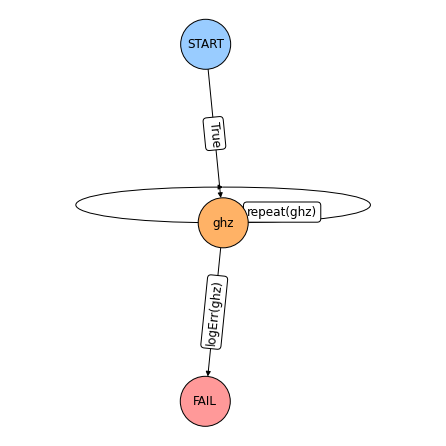

In [ ]:
from qsam.circuit import Circuit
from qsam.protocol import Protocol, draw_protocol

ghz = Circuit([ {"init": {0,1,2,3,4}},
                {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ])

def repeat(m):
    return len(m) < 3 and m[-1] == 1
    
def logErr(m):
    return len(m) >= 3 and m[-1] == 1 and m[-2] == 1 and m[-3] == 1

functions = {'logErr': logErr, 'repeat': repeat}

g = Protocol()
g.add_nodes_from(['ghz'], circuits=[ghz])

g.add_edge('START', 'ghz', check='True')

g.add_edge('ghz', 'ghz', check='repeat(ghz)')
g.add_edge('ghz', 'FAIL', check='logErr(ghz)')

draw_protocol(g, figsize=(6,6))

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator

sample_range = np.logspace(-3,0,10)
err_params = {'p': 1}

sam = Sampler(g, ChpSimulator)
p_L, std = sam.run(10000, sample_range, err_params, RSE_target=1e-1, eval_fns=functions)

 73%|█████████████████████████████████████████▌               | 7284/10000 [00:04<00:01, 1756.52it/s]


RSE target of 0.1 reached.


 30%|████████████████▊                                        | 2953/10000 [00:02<00:05, 1295.48it/s]


RSE target of 0.1 reached.


 25%|██████████████▋                                           | 2538/10000 [00:02<00:08, 899.86it/s]

RSE target of 0.1 reached.


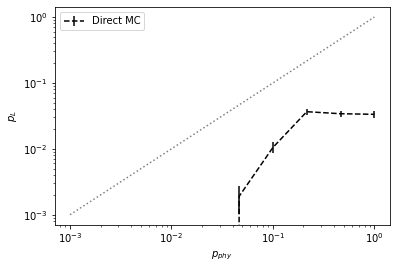

In [ ]:
#hide_input
#slow

import matplotlib.pyplot as plt

p = sample_range

plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$p_L$')
plt.xlabel(r'$p_{phy}$')
plt.legend();

In [ ]:
show_doc(Sampler)

<h2 id="Sampler" class="doc_header"><code>class</code> <code>Sampler</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>Sampler</code>(**`protocol`**, **`simulator`**)



For the `SubsetSampler` we want to sample from specific fault-weight-subsets upto a certain maximum weight $w_{max}$. The benefit of this approach is that we can scale each of the resulting failure rates by analytically calculated `subset_occurances` for each `p_phy` which then gives us `p_L(p_phy)` for all `p_phy` without any additional sampling required. The subset sampler chooses the next fault-weight subset that is used when sampling from the next circuit in the protocol by the minimum sampled subset for a given circuit, which results in a balanced sampling over all subsets for a circuit. Additionally, one can exclude sampling for all circuits in a protocol from certain subsets by specifying a *list of ints* of `w_exclude` fault-weights. Overall, this approach of choosing the subsets and defining the weight threshold is not ideal. The dynamic subset sampler includes methods to improve on both of these points.

In [ ]:
# export

class SubsetSampler(SubsetAnalytics):
    """Subset Sampler of quantum protocols"""
    
    def __init__(self, protocol, simulator):
        self.protocol = protocol
        self.simulator = simulator
        self.n_qubits = len(set(q for c in protocol._circuits.values() for q in unpack(c)))
        self.tree = Tree()
        
    def run(self, n_samples, sample_range, err_params, chi_min=1e-2, p_max=0.1, RSE_target=1e-1, ERV_sel=True, var=math.Wilson_var, eval_fns={}):
        
        p_phy_per_partition = np.array([[p_phy * mul for p_phy in sample_range] for mul in err_params.values()]).T
        partitions = {circuit_hash: [partition(circuit, GATE_GROUPS[k]) for k in err_params.keys()]
                      for circuit_hash, circuit in self.protocol._circuits.items() if circuit._noisy}
        w_vecs = {circuit_hash: SubsetSampler.weight_vectors([len(p) for p in pars]) 
                  for circuit_hash, pars in partitions.items()}
        Aws = {circuit_hash: SubsetSampler.subset_occurence(partitions[circuit_hash], w_vecs, p_phy_per_partition)
               for circuit_hash, w_vecs in w_vecs.items()}
        
        Aws_at_p_max = {circuit_hash: SubsetSampler.subset_occurence(partitions[circuit_hash], w_vecs, np.array(p_max))
                        for circuit_hash, w_vecs in w_vecs.items()}
        
        for _ in tqdm(range(n_samples)):

            chi = 1
            sim = self.simulator(self.n_qubits)
            p_it = iterate(self.protocol, eval_fns)
            node = next(p_it)
            tree_node = self.tree.add(name=node, node_cls=CountNode)
            tree_node.counts += 1
                                    
            while node:
                
                if not self.protocol.out_edges(node): 
                    break # terminal node reached
                
                circuit_hash, circuit = self.protocol.circuit_from_node(node)
                
                if circuit_hash not in partitions.keys(): # handle circuits created at runtime
                    msmt = sim.run(circuit)
                    tree_node = self.tree.add(name=(0,), 
                                              node_cls=Constant,
                                              parent=tree_node,
                                              data={'Aw': np.ones(shape=p_phy_per_partition.shape[0]), 
                                                    'Aw_p_max': np.array([1])})
                else:
                    ids = np.where(chi * Aws_at_p_max[circuit_hash] > chi_min)[0]
                    if len(ids) == 0 or not circuit._noisy: 
                        idx = 0 
                    else:
                        delta = self.tree.delta(ckey='Aw_p_max')
                        v_L = self.tree.var(ckey='Aw_p_max')
                        p_L = self.tree.rate(ckey='Aw_p_max')

                        if not ERV_sel:
                            idx = np.random.choice(ids)
                        else:
                            erv_deltas = []
                            for idx in ids:
                                Aw = Aws[circuit_hash][idx]
                                Aw_p_max = Aws_at_p_max[circuit_hash][idx]
                                w_vec = w_vecs[circuit_hash][idx]

                                _tree_node = self.tree.add(w_vec, node_cls=Constant, parent=tree_node, data={'Aw': Aw, 'Aw_p_max': Aw_p_max})
                                __tree_node = self.tree.add('FAIL', node_cls=Fail, parent=_tree_node)
                                _delta = self.tree.delta(ckey='Aw_p_max')
                                _rate = __tree_node.rate

                                _tree_node.counts += 1
                                v_L_minus = self.tree.var(ckey='Aw_p_max')

                                __tree_node.counts += 1
                                v_L_plus = self.tree.var(ckey='Aw_p_max')

                                _v_L = _rate * v_L_plus + (1 - _rate) * v_L_minus
                                erv_delta = np.abs(v_L - _v_L) + (delta - _delta)
                                erv_deltas.append( erv_delta )

                                # revert the change
                                _tree_node.counts -= 1
                                __tree_node.counts -= 1
                                if _tree_node.counts == 0: self.tree.detach(_tree_node)
                                if __tree_node.counts == 0: self.tree.detach(__tree_node)

                            idx = np.argmax(erv_deltas)
                            idx = ids[idx]

                    Aw = Aws[circuit_hash][idx]
                    Aw_p_max = Aws_at_p_max[circuit_hash][idx]
                    w_vec = w_vecs[circuit_hash][idx]
                    chi *= Aw_p_max

                    faults = Depolar.faults_from_weights(partitions[circuit_hash], w_vec)
                    fault_circuit = Depolar.gen_circuit(len(circuit), faults)
                    msmt = sim.run(circuit, fault_circuit)

                    tree_node = self.tree.add(name=w_vec, node_cls=Constant, parent=tree_node, data={'Aw': Aw, 'Aw_p_max': Aw_p_max},
                                              deterministic=True if circuit._ff_deterministic and not any(w_vec) else False)
                    
                tree_node.counts += 1
                node = p_it.send(msmt if msmt==None else int(msmt,2)) # exchange with iterator 
                
                if node == None: name, node_cls = "NO FAIL", NoFail
                elif node == 'FAIL': name, node_cls = node, Fail
                else: name, node_cls = node, Variable
                tree_node = self.tree.add(name=name, node_cls=node_cls, parent=tree_node)
                tree_node.counts += 1
                
            
            if p_L > 0 and (np.sqrt(v_L) + delta) / p_L < RSE_target: 
                print(f'RSE target of {RSE_target} reached.') 
                break
         
        v_L = self.tree.var(ckey='Aw')
        p_L_low = self.tree.rate(ckey='Aw')
        p_L_low = np.zeros_like(v_L) if type(p_L_low) == int else p_L_low # if all paths fault free: return array of 0s
        p_L_up = p_L_low + self.tree.delta(ckey='Aw')
               
        return p_L_low, p_L_up, np.sqrt(v_L)
    
    def __str__(self):
        return self.tree.__str__()

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator as CHP

sample_range = np.logspace(-3,0,10)
err_params = {'p': 1}

sam = SubsetSampler(g, CHP)
p_L_low, p_L_up, ss_std = sam.run(1000, sample_range, err_params, ERV_sel=True, RSE_target=0.8, chi_min=1e-2, p_max=0.08, eval_fns=functions)
print(sam)

100%|███████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 392.85it/s]

ghz (1000/1000)
├── (0,) (Aw: 9.94e-01,...,0.00e+00, Aw_p_max: 6.06e-01)
│   └── NO FAIL (617/617, 9.57e-06)
├── (1,) (Aw: 5.97e-03,...,0.00e+00, Aw_p_max: 3.16e-01)
│   ├── NO FAIL (169/317, 2.98e-03)
│   └── ghz (148/317, 2.98e-03)
│       ├── (0,) (Aw: 9.94e-01,...,0.00e+00, Aw_p_max: 6.06e-01)
│       │   └── NO FAIL (96/96, 3.70e-04)
│       ├── (1,) (Aw: 5.97e-03,...,0.00e+00, Aw_p_max: 3.16e-01)
│       │   ├── ghz (20/45, 1.94e-02)
│       │   │   ├── (0,) (Aw: 9.94e-01,...,0.00e+00, Aw_p_max: 6.06e-01)
│       │   │   │   └── NO FAIL (17/17, 8.49e-03)
│       │   │   └── (1,) (Aw: 5.97e-03,...,0.00e+00, Aw_p_max: 3.16e-01)
│       │   │       ├── EXIT (2/3, 1.34e-01)
│       │   │       └── NO FAIL (1/3, 1.34e-01)
│       │   └── NO FAIL (25/45, 1.94e-02)
│       └── (2,) (Aw: 1.49e-05,...,0.00e+00, Aw_p_max: 6.88e-02)
│           ├── NO FAIL (4/7, 8.74e-02)
│           └── ghz (3/7, 8.74e-02)
│               └── (0,) (Aw: 9.94e-01,...,0.00e+00, Aw_p_max: 6.06e-01)
│          

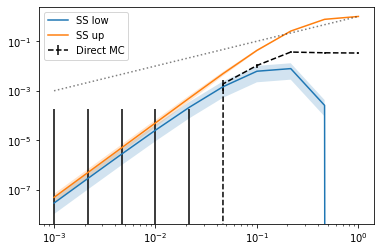

In [ ]:
#slow
#hide_input

import matplotlib.pyplot as plt

p = sample_range
plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p_L_low, label="SS low")
plt.fill_between(p, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)

plt.plot(p, p_L_up, label="SS up")
plt.fill_between(p, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

In [ ]:
show_doc(SubsetSampler)

<h2 id="SubsetSampler" class="doc_header"><code>class</code> <code>SubsetSampler</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>SubsetSampler</code>(**`protocol`**, **`simulator`**) :: [`SubsetAnalytics`](/qsam/samplers.sampler_mixins.html#SubsetAnalytics)

Subset Sampler of quantum protocols

**Documentation & plots missing...**